----------
**Pima Indians Diabetes - Prediction**
=====================================

![](https://cdn.britannica.com/42/93542-050-E2B32DAB.jpg)

Hello All !!

This notebook is a guide to end to end a complete study in machine learning with different concepts like :

* Completing missing values (most important part)
* Exploratory data analysis
* Creating new features (to increase accuracy)
* Encoding features
* Using LightGBM and optimize hyperparameters
* Adding a KNN to LGBM to beat 90% accuracy (voting classifier)

# Who are Pima Indians ?

"The Pima (or Akimel O'odham, also spelled Akimel O'otham, "River People", formerly known as Pima) are a group of Native Americans living in an area consisting of what is now central and southern Arizona. The majority population of the surviving two bands of the Akimel O'odham are based in two reservations: the Keli Akimel O'otham on the Gila River Indian Community (GRIC) and the On'k Akimel O'odham on the Salt River Pima-Maricopa Indian Community (SRPMIC)." Wikipedia


- <a href='#1'>1. Load libraries and read the data</a>  

    
- <a href='#2'>2. Target</a> 

   
    
- <a href='#3'>3. Replace missing values</a>

    - <a href='#3.1'>3.1. Insulin</a> 
    - <a href='#3.2'>3.2. Glucose</a> 
    - <a href='#3.3'>3.3. SkinThickness</a>
    - <a href='#3.4'>3.4. BloodPressure</a>
    - <a href='#3.5'>3.5. BMI</a>
    


- <a href='#4'>4. Prepare dataset</a> 
    - <a href='#4.1'>4.1. StandardScaler and LabelEncoder</a> 
    
- <a href='#5'>5. Model Performance</a> 
    
- <a href='#6'>6.Machine Learning</a> 

    - <a href='#6.1'>6.1. RandomSearch + LightGBM - Accuracy = 89.8%</a> 
    - <a href='#6.2'>6.2. LightGBM - Discrimination Threshold</a>
    - <a href='#6.3'>6.3. GBM (Accuracy 88.28%)</a>
    - <a href='#6.4'>6.4. XGBOOST (Accuracy 87.5%)</a>
    - <a href='#6.5'>6.5. Using SMOTE (Synthetic Minority Over-sampling Technique) (Accuracy 89.66%)</a>
    


# <a id='1'>1. Load libraries and read the data</a> 

Loading the libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline


from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import precision_score, recall_score, confusion_matrix,  roc_curve, precision_recall_curve, accuracy_score, roc_auc_score
import lightgbm as lgbm
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.metrics import classification_report


Loading dataset with pandas (pd)

In [2]:
data = pd.read_csv('F:/ML-Problems/Pima Indians Diabetes/data/diabetes.csv')

In [3]:
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
data.shape

(768, 9)

# What is diabetes ? 
Acccording to NIH, "**Diabetes** is a disease that occurs when your blood glucose, also called blood sugar, is too high. Blood glucose is your main source of energy and comes from the food you eat. Insulin, a hormone made by the pancreas, helps glucose from food get into your cells to be used for energy. Sometimes your body doesn’t make enough—or any—insulin or doesn’t use insulin well. Glucose then stays in your blood and doesn’t reach your cells.

Over time, having too much glucose in your blood can cause health problems. Although diabetes has no cure, you can take steps to manage your diabetes and stay healthy.

Sometimes people call diabetes “a touch of sugar” or “borderline diabetes.” These terms suggest that someone doesn’t really have diabetes or has a less serious case, but every case of diabetes is serious.

**What are the different types of diabetes?**
The most common types of diabetes are type 1, type 2, and gestational diabetes.

**Type 1 diabetes**
If you have type 1 diabetes, your body does not make insulin. Your immune system attacks and destroys the cells in your pancreas that make insulin. Type 1 diabetes is usually diagnosed in children and young adults, although it can appear at any age. People with type 1 diabetes need to take insulin every day to stay alive.

**Type 2 diabetes**
If you have type 2 diabetes, your body does not make or use insulin well. You can develop type 2 diabetes at any age, even during childhood. However, this type of diabetes occurs most often in middle-aged and older people. Type 2 is the most common type of diabetes.

**Gestational diabetes**
Gestational diabetes develops in some women when they are pregnant. Most of the time, this type of diabetes goes away after the baby is born. However, if you’ve had gestational diabetes, you have a greater chance of developing type 2 diabetes later in life. Sometimes diabetes diagnosed during pregnancy is actually type 2 diabetes.

**Other types of diabetes**
Less common types include monogenic diabetes, which is an inherited form of diabetes, and cystic fibrosis-related diabetes ."

## <a id='2'>2. Target</a> 

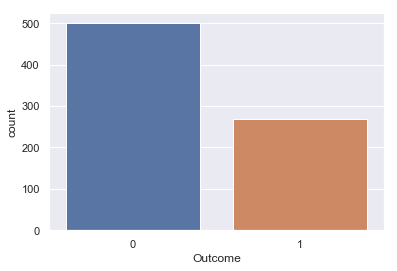

In [5]:
sns.countplot(x = 'Outcome', data = data)

## <a id='3'>3. Missing values</a> 

We saw on data.head() that some features contain 0, it doesn't make sense here and this indicates missing value
Below we replace 0 value by NaN :

In [6]:
data[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']] = data[[
    'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']].replace(0, np.NaN)

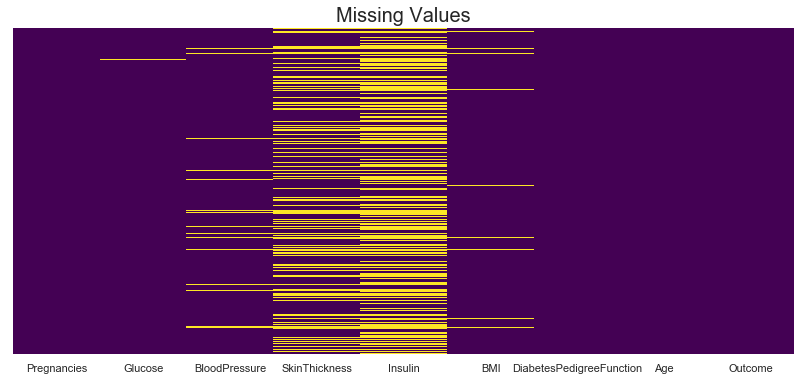

In [7]:
# Look at missing data.
plt.figure(figsize=(14,6))

p = sns.heatmap(data.isnull(),
                yticklabels=False,
                cbar=False,
                cmap='viridis')

p.axes.set_title("Missing Values",fontsize=20);

We see lot of values are missing in Insulin and SkinThickness

**To fill these Nan values the data distribution needs to be understood against the target**. 

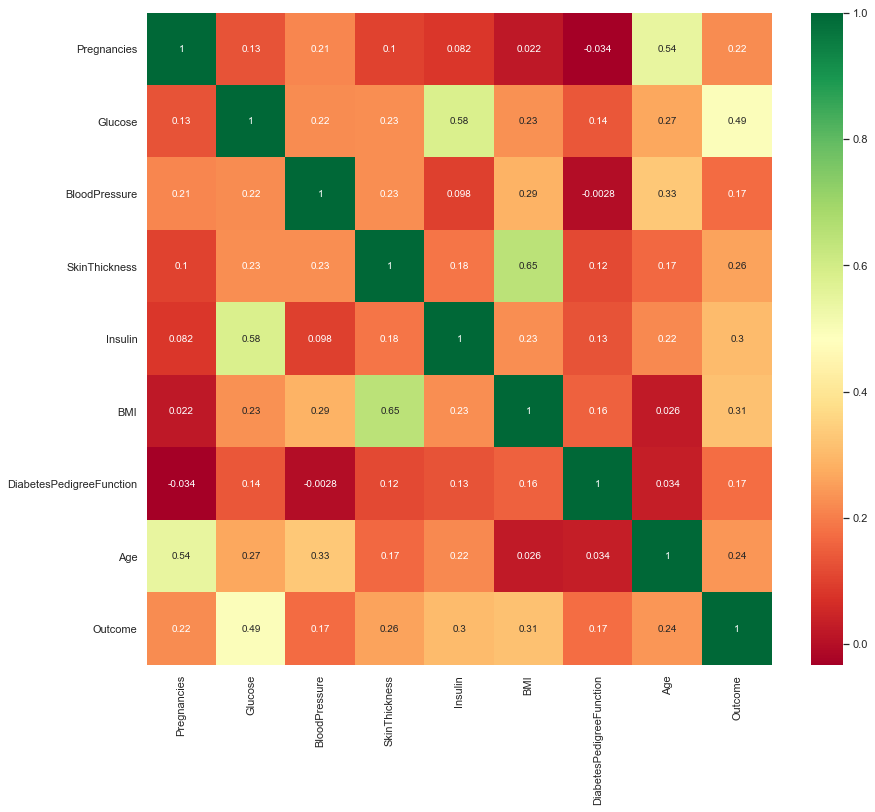

In [8]:
sns.heatmap(data[data.columns[:]].corr(),annot=True,cmap='RdYlGn')
fig=plt.gcf()
fig.set_size_inches(14,12)
plt.show()

From the two variable highly correlated, here we drop the one which is less correlated with Target (Outcome)

From the above Insulin and SkinThickness can be removed

To replace missing values, we'll use median by target (Outcome)

In [9]:
def median_target(var):   
    temp = data[data[var].notnull()]
    temp = temp[[var, 'Outcome']].groupby(['Outcome'])[[var]].median().reset_index()
    return temp

## <a id='3.1'>3.1. Insulin</a> 

In [10]:
median_target('Insulin')

,Outcome,Insulin
0,0,102.5
1,1,169.5


Insulin's medians by the target are really different ! 102.5 for a healthy person and 169.5 for a diabetic person

In [11]:
data.loc[(data['Outcome'] == 0 ) & (data['Insulin'].isnull()), 'Insulin'] = 102.5
data.loc[(data['Outcome'] == 1 ) & (data['Insulin'].isnull()), 'Insulin'] = 169.5

## <a id='3.2'>3.2. Glucose</a> 

In [12]:
median_target('Glucose')

,Outcome,Glucose
0,0,107.0
1,1,140.0


107 for a healthy person and 140 for a diabetic person

In [13]:
data.loc[(data['Outcome'] == 0 ) & (data['Glucose'].isnull()), 'Glucose'] = 107
data.loc[(data['Outcome'] == 1 ) & (data['Glucose'].isnull()), 'Glucose'] = 140

## <a id='3.3'>3.3. SkinThickness</a> 

In [14]:
median_target('SkinThickness')

,Outcome,SkinThickness
0,0,27.0
1,1,32.0


In [15]:
data.loc[(data['Outcome'] == 0 ) & (data['SkinThickness'].isnull()), 'SkinThickness'] = 27
data.loc[(data['Outcome'] == 1 ) & (data['SkinThickness'].isnull()), 'SkinThickness'] = 32

## <a id='3.4'>3.4. BloodPressure</a> 

In [16]:
median_target('BloodPressure')

,Outcome,BloodPressure
0,0,70.0
1,1,74.5


In [17]:
data.loc[(data['Outcome'] == 0 ) & (data['BloodPressure'].isnull()), 'BloodPressure'] = 70
data.loc[(data['Outcome'] == 1 ) & (data['BloodPressure'].isnull()), 'BloodPressure'] = 74.5

## <a id='3.5'>3.5. BMI</a> 

In [18]:
median_target('BMI')

,Outcome,BMI
0,0,30.1
1,1,34.3


In [19]:
data.loc[(data['Outcome'] == 0 ) & (data['BMI'].isnull()), 'BMI'] = 30.1
data.loc[(data['Outcome'] == 1 ) & (data['BMI'].isnull()), 'BMI'] = 34.3

In [20]:
data.nunique()

Pregnancies                  17
Glucose                     135
BloodPressure                47
SkinThickness                50
Insulin                     187
BMI                         247
DiabetesPedigreeFunction    517
Age                          52
Outcome                       2
dtype: int64

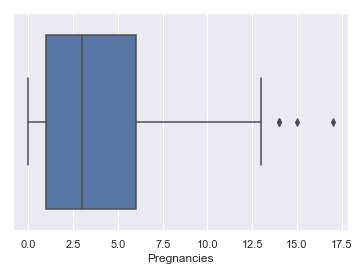

In [21]:
sns.boxplot(x='Pregnancies', data=data)
fig=plt.gcf()
#fig.set_size_inches(14,12)

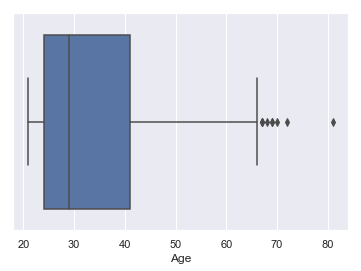

In [22]:
sns.boxplot(x='Age', data=data)
fig=plt.gcf()

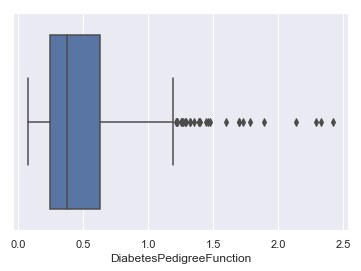

In [23]:
sns.boxplot(x='DiabetesPedigreeFunction', data=data)
fig=plt.gcf()

Many outliers

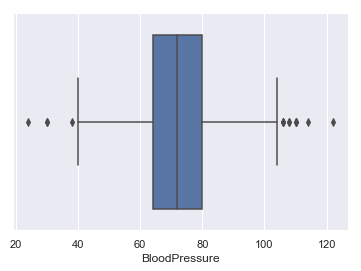

In [24]:
sns.boxplot(x='BloodPressure', data=data)
fig=plt.gcf()

In [25]:
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,169.5,33.6,0.627,50,1
1,1,85.0,66.0,29.0,102.5,26.6,0.351,31,0
2,8,183.0,64.0,32.0,169.5,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1


In [26]:
data['Pregnancies'].value_counts()

1     135
0     111
2     103
3      75
4      68
5      57
6      50
7      45
8      38
9      28
10     24
11     11
13     10
12      9
14      2
15      1
17      1
Name: Pregnancies, dtype: int64

In [27]:

# calculate frequency of categories in the columns
k=data['Pregnancies'].value_counts(dropna=False)
# ignoring categories with too low frequencies and then selecting n-1to create dummies for
cats=k.index[k>50][:-1]
# creating dummies for remaining categories
for cat in cats:
# creating name of the dummy column coresponding to the category
    name='Preg'+'_'+str(cat)
# adding the column to data
    data[name]=(data['Pregnancies']==cat).astype(int)
# removing the original column once we are done creating dummies forit
del data['Pregnancies']

# <a id='4'>4. Prepare dataset</a> 

## <a id='4.1'>4.1. StandardScaler and LabelEncoder</a> 

* ** StandardScaler** :

Standardize features by removing the mean and scaling to unit variance : 

![](http://image.noelshack.com/fichiers/2019/06/1/1549282952-0-0-0-0-0-0.png)

Centering and scaling happen independently on each feature by computing the relevant statistics on the samples in the set. Mean and standard deviation are then stored to be used on later data using the transform method.

Standardization of a dataset is a common requirement for many machine learning estimators: they might behave badly if the individual features do not more or less look like standard normally distributed data (e.g. Gaussian with 0 mean and unit variance).

* ** LabelEncoder** : Encode labels with value between 0 and n_classes-1.

Bellow we encode the data to feed properly to our algorithm

In [28]:
data.head()

,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Preg_1,Preg_0,Preg_2,Preg_3,Preg_4
0,148.0,72.0,35.0,169.5,33.6,0.627,50,1,0,0,0,0,0
1,85.0,66.0,29.0,102.5,26.6,0.351,31,0,1,0,0,0,0
2,183.0,64.0,32.0,169.5,23.3,0.672,32,1,0,0,0,0,0
3,89.0,66.0,23.0,94.0,28.1,0.167,21,0,1,0,0,0,0
4,137.0,40.0,35.0,168.0,43.1,2.288,33,1,0,1,0,0,0


In [29]:
from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()

In [30]:
x =  pd.DataFrame(sc_x.fit_transform(data.drop(["Outcome"],axis = 1),),
        columns=['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Preg_0','Preg_1', 'Preg_2', 'Preg_3', 'Preg_4'])

In [31]:
x.head()

,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Preg_0,Preg_1,Preg_2,Preg_3,Preg_4
0,0.864625,-0.032180,0.665181,0.311604,0.169483,0.468492,1.425995,-0.461812,-0.411035,-0.393557,-0.328976,-0.311677
1,-1.204727,-0.528124,-0.010112,-0.440843,-0.848549,-0.365061,-0.190672,2.165384,-0.411035,-0.393557,-0.328976,-0.311677
2,2.014265,-0.693438,0.327535,0.311604,-1.328478,0.604397,-0.105584,-0.461812,-0.411035,-0.393557,-0.328976,-0.311677
3,-1.073339,-0.528124,-0.685405,-0.536303,-0.630399,-0.920763,-1.041549,2.165384,-0.411035,-0.393557,-0.328976,-0.311677
4,0.503310,-2.677212,0.665181,0.294758,1.551096,5.484909,-0.020496,-0.461812,2.432883,-0.393557,-0.328976,-0.311677


In [32]:
y = data.Outcome

## <a id='5'>5. Model Performance</a> 

To measure the performance of a model, we need several elements :

This part is essential

* **Confusion matrix** : also known as the error matrix, allows visualization of the performance of an algorithm :

    * true positive (TP) : Diabetic correctly identified as diabetic
    * true negative (TN) : Healthy correctly identified as healthy
    * false positive (FP) : Healthy incorrectly identified as diabetic
    * false negative (FN) : Diabetic incorrectly identified as healthy

![](https://image.noelshack.com/fichiers/2018/20/5/1526651914-cs-heezweaa5hp7.jpg)

* **Metrics ** :

    * Accuracy : (TP +TN) / (TP + TN + FP +FN)
    * Precision : TP / (TP + FP)
    * Recall : TP / (TP + FN)
    * F1 score : 2 x ((Precision x Recall) / (Precision + Recall))

* **Roc Curve** : The ROC curve is created by plotting the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings.

![](http://image.noelshack.com/fichiers/2019/06/1/1549284841-0-0-0-0-0-0-0-0-0-0.png)

* **Precision Recall Curve** :  shows the tradeoff between precision and recall for different threshold

In [33]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] ==i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.5f} (std: {1:.5f})".format(
                results['mean_test_score'][candidate],
                results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

# <a id='6'>6. Machine Learning</a> 

## <a id='6.1'>6.1. RandomSearch + LightGBM - Accuracy = 87.5%</a> 

![](http://image.noelshack.com/fichiers/2019/06/1/1549285917-0000000000000000000.png)

** LightGBM** is a gradient boosting framework that uses tree based learning algorithms. It is designed to be distributed and efficient with the following advantages:

* Faster training speed and higher efficiency.
* Lower memory usage.
* Better accuracy.
* Support of parallel and GPU learning.
* Capable of handling large-scale data.

To find the best hyperparameters, we'll use Random Search CV.

Random search is a technique where random combinations of the hyperparameters are used to find the best solution for the built model. 
Generally RS is more faster and accurate than GridSearchCV who calculate all possible combinations. With Random Grid we specify the number of combinations that we want

In [34]:
from sklearn.model_selection import train_test_split

In [35]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=1/3,random_state=42, stratify=y)

In [36]:
import scipy.stats as ss
from scipy import interp
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

In [37]:
random_state=42

fit_params = {"early_stopping_rounds" : 100, 
             "eval_metric" : 'auc', 
             "eval_set" : [(x_test,y_test)],
             'eval_names': ['valid'],
             'verbose': 0,
             'categorical_feature': 'auto'}

param_test = {'learning_rate' : [0.01, 0.02, 0.03, 0.04, 0.05, 0.08, 0.1, 0.2, 0.3, 0.4],
              'n_estimators' : [100, 200, 300, 400, 500, 600, 800, 1000, 1500, 2000],
              'num_leaves': sp_randint(6, 50), 
              'min_child_samples': sp_randint(100, 500), 
              'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
              'subsample': sp_uniform(loc=0.2, scale=0.8), 
              'max_depth': [-1, 1, 2, 3, 4, 5, 6, 7],
              'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
              'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
              'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

#number of combinations
n_iter = 50

#intialize lgbm and lunch the search
lgbm_clf = lgbm.LGBMClassifier(random_state=random_state, silent=True, metric='None', n_jobs=4)
grid_search = RandomizedSearchCV(
    estimator=lgbm_clf, param_distributions=param_test, 
    n_iter=n_iter,
    scoring='accuracy',
    cv=5,
    refit=True,
    random_state=random_state,
    verbose=True)

grid_search.fit(x_train, y_train, **fit_params)
opt_parameters =  grid_search.best_params_
lgbm_clf = lgbm.LGBMClassifier(**opt_parameters)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:   14.4s finished
C:\Users\SAIF\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [38]:
report(grid_search.cv_results_, 3)

Model with rank: 1
Mean validation score: 0.85742 (std: 0.04177)
Parameters: {'colsample_bytree': 0.5536409936567944, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_samples': 114, 'min_child_weight': 0.01, 'n_estimators': 800, 'num_leaves': 37, 'reg_alpha': 2, 'reg_lambda': 20, 'subsample': 0.31146516352470055}

Model with rank: 2
Mean validation score: 0.84961 (std: 0.05362)
Parameters: {'colsample_bytree': 0.4489565082401442, 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 135, 'min_child_weight': 0.1, 'n_estimators': 100, 'num_leaves': 13, 'reg_alpha': 1, 'reg_lambda': 50, 'subsample': 0.22209341749896377}

Model with rank: 3
Mean validation score: 0.81641 (std: 0.05828)
Parameters: {'colsample_bytree': 0.8818838538279375, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_samples': 197, 'min_child_weight': 10.0, 'n_estimators': 600, 'num_leaves': 16, 'reg_alpha': 0, 'reg_lambda': 0, 'subsample': 0.4566240519773887}



In [39]:
y_pred = grid_search.predict(x_test)

In [40]:
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.89      0.90       167
           1       0.81      0.84      0.82        89

   micro avg       0.88      0.88      0.88       256
   macro avg       0.86      0.87      0.86       256
weighted avg       0.88      0.88      0.88       256

[[149  18]
 [ 14  75]]


In [41]:
accuracy_score(y_pred, y_test)

0.875

## <a id='6.2'>6.2. GridSearch + LightGBM & KNN- Accuracy = 87.1%</a> 

We obtain a really good result but we can beat 90% with adding a KNeighborsClassifier to LightGBM (Voting Classifier)

* **KNeighborsClassifier** : KNeighborsClassifier implements learning based on the k nearest neighbors of each query point, where  k is an integer value specified by the user.

* **VotingClassifier** : VotingClassifier is a meta-classifier for combining similar or conceptually different machine learning classifiers for classification via majority or plurality voting

With GridSearch CV we search the best "n_neighbors" to optimize accuracy of Voting Classifier

In [42]:
knn_clf = KNeighborsClassifier()

voting_clf = VotingClassifier(estimators=[ 
    ('lgbm_clf', lgbm_clf),
    ('knn', KNeighborsClassifier())], voting='soft', weights = [2.5,1])

params = {
      'knn__n_neighbors': np.arange(1,30)
      }
      
grid = GridSearchCV(estimator=voting_clf, param_grid=params, cv=10)

grid.fit(x_train,y_train)

print("Best Score:" + str(grid.best_score_))
print("Best Parameters: " + str(grid.best_params_))

Best Score:0.859375
Best Parameters: {'knn__n_neighbors': 6}


C:\Users\SAIF\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [43]:
knn_clf = KNeighborsClassifier(n_neighbors = 2)

voting_clf = VotingClassifier (
        estimators = [('knn', knn_clf), ('lgbm', lgbm_clf)],
                     voting='soft', weights = [1,3])

voting_clf.fit(x_train, y_train)

VotingClassifier(estimators=[('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=2, p=2,
           weights='uniform')), ('lgbm', LGBMClassifier(boosting_type='gbdt', class_weight=None,
        colsample_bytree=0.5536409936567944, i...t=True,
        subsample=0.31146516352470055, subsample_for_bin=200000,
        subsample_freq=0))],
         flatten_transform=None, n_jobs=None, voting='soft',
         weights=[1, 3])

In [44]:

# Calculating the accuracies
print("Training accuracy :", voting_clf.score(x_train, y_train))
print("Testing accuracy :", voting_clf.score(x_test, y_test))

y_pred = voting_clf.predict(x_test)
# classification report
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Training accuracy : 0.91015625
Testing accuracy : 0.87109375
              precision    recall  f1-score   support

           0       0.91      0.89      0.90       167
           1       0.80      0.83      0.82        89

   micro avg       0.87      0.87      0.87       256
   macro avg       0.86      0.86      0.86       256
weighted avg       0.87      0.87      0.87       256

[[149  18]
 [ 15  74]]


In [45]:
accuracy_score(y_test, y_pred)

0.87109375

## <a id='6.3'>6.3. GBM (Accuracy 88.28%)</a> 

In [46]:
gbm_params={'n_estimators':[50,100,200],
'learning_rate': [0.01,.05,0.1,0.4,0.8,1],
'max_depth':[1,2,3,4,5,6],
'subsample':[0.5,0.8,1],
'max_features':[0.1, 0.25, 0.4]
}

In [47]:
from sklearn.ensemble import GradientBoostingClassifier
model = GradientBoostingClassifier()

In [48]:
from sklearn.model_selection import RandomizedSearchCV

In [49]:
random_search=RandomizedSearchCV(model,scoring='roc_auc',
                param_distributions=gbm_params,
                cv=10,n_iter=10,
                verbose=False)

In [50]:
random_search.fit(x_train,y_train)

C:\Users\SAIF\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomizedSearchCV(cv=10, error_score='raise-deprecating',
          estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.05, 0.1, 0.4, 0.8, 1], 'max_depth': [1, 2, 3, 4, 5, 6], 'subsample': [0.5, 0.8, 1], 'max_features': [0.1, 0.25, 0.4]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='roc_auc', verbose=False)

In [51]:
report(random_search.cv_results_, 3)

Model with rank: 1
Mean validation score: 0.93664 (std: 0.04282)
Parameters: {'subsample': 1, 'n_estimators': 200, 'max_features': 0.4, 'max_depth': 4, 'learning_rate': 0.01}

Model with rank: 2
Mean validation score: 0.93446 (std: 0.04474)
Parameters: {'subsample': 1, 'n_estimators': 100, 'max_features': 0.4, 'max_depth': 5, 'learning_rate': 0.05}

Model with rank: 3
Mean validation score: 0.93198 (std: 0.04718)
Parameters: {'subsample': 0.5, 'n_estimators': 200, 'max_features': 0.25, 'max_depth': 1, 'learning_rate': 0.05}



In [52]:
y_pred = random_search.predict(x_test)

In [53]:
accuracy_score(y_pred, y_test)

0.8828125

## <a id='6.4'>6.4. XGBOOST (Accuracy 87.5%)</a> 

In [54]:
from xgboost.sklearn import XGBClassifier

In [55]:
from sklearn.model_selection import GridSearchCV

In [56]:
xgb_params = {
"n_estimators":[100,500,700,900,1000,1200,1500]
}
xgb1=XGBClassifier(subsample=0.8,colsample_bylevel=0.8,colsample_bytree=0.8)
grid_search=GridSearchCV(xgb1,cv=5,param_grid=xgb_params,
                scoring='roc_auc',verbose=False)

In [57]:
grid_search.fit(x_train,y_train)
report(grid_search.cv_results_,3)

Model with rank: 1
Mean validation score: 0.93495 (std: 0.02230)
Parameters: {'n_estimators': 100}

Model with rank: 2
Mean validation score: 0.93060 (std: 0.02705)
Parameters: {'n_estimators': 500}

Model with rank: 3
Mean validation score: 0.93041 (std: 0.02784)
Parameters: {'n_estimators': 700}



In [58]:
xgb_params={
        "gamma":[0,2,5,8,10],
        "max_depth": [2,3,4,5,6,7,8],
        "min_child_weight":[0.5,1,2,5,10]
    }

In [59]:
xgb2=XGBClassifier(n_estimators=100,subsample=0.8,
            colsample_bylevel=0.8,colsample_bytree=0.8)

In [60]:
random_search=RandomizedSearchCV(xgb2,param_distributions=xgb_params,n_iter=20,
                cv=5,scoring='roc_auc',
                verbose=False)

In [61]:
random_search.fit(x_train,y_train)
report(random_search.cv_results_,3)

Model with rank: 1
Mean validation score: 0.94366 (std: 0.02067)
Parameters: {'min_child_weight': 5, 'max_depth': 4, 'gamma': 0}

Model with rank: 2
Mean validation score: 0.94325 (std: 0.02081)
Parameters: {'min_child_weight': 5, 'max_depth': 8, 'gamma': 0}

Model with rank: 3
Mean validation score: 0.94031 (std: 0.02511)
Parameters: {'min_child_weight': 2, 'max_depth': 6, 'gamma': 2}



In [62]:
y_pred = random_search.predict(x_test)

In [63]:
accuracy_score(y_pred, y_test)

0.8671875

In [64]:
xgb_params={
        'max_delta_step':[0,1,3,6,10],
        'scale_pos_weight':[1,2,3,4]
    }

In [65]:
xgb3=XGBClassifier(n_estimators=100,min_child_weight=5,gamma=0,max_depth=2,
                subsample=0.8,colsample_bylevel=0.8,colsample_bytree=0.8)

In [66]:
grid_search=GridSearchCV(xgb3,param_grid=xgb_params,
            cv=5,scoring='roc_auc',verbose=False)

In [67]:
grid_search.fit(x_train,y_train)
report(grid_search.cv_results_,3)

Model with rank: 1
Mean validation score: 0.94468 (std: 0.02008)
Parameters: {'max_delta_step': 0, 'scale_pos_weight': 1}

Model with rank: 1
Mean validation score: 0.94468 (std: 0.02008)
Parameters: {'max_delta_step': 3, 'scale_pos_weight': 1}

Model with rank: 1
Mean validation score: 0.94468 (std: 0.02008)
Parameters: {'max_delta_step': 6, 'scale_pos_weight': 1}

Model with rank: 1
Mean validation score: 0.94468 (std: 0.02008)
Parameters: {'max_delta_step': 10, 'scale_pos_weight': 1}



In [68]:
xgb_params={
'subsample':[i/10 for i in range(5,11)],
'colsample_bytree':[i/10 for i in range(5,11)],
'colsample_bylevel':[i/10 for i in range(5,11)]
}
xgb4=XGBClassifier(n_estimators=100,min_child_weight=5,gamma=0,max_depth=2,
                scale_pos_weight=1,max_delta_step=0
            )
random_search=RandomizedSearchCV(xgb4,param_distributions=xgb_params,
                    cv=5,n_iter=20,scoring='roc_auc',
                    verbose=False)

In [69]:
random_search.fit(x_train,y_train)
report(random_search.cv_results_,3)

Model with rank: 1
Mean validation score: 0.94664 (std: 0.02246)
Parameters: {'subsample': 0.9, 'colsample_bytree': 0.5, 'colsample_bylevel': 1.0}

Model with rank: 2
Mean validation score: 0.94505 (std: 0.02263)
Parameters: {'subsample': 1.0, 'colsample_bytree': 0.6, 'colsample_bylevel': 1.0}

Model with rank: 3
Mean validation score: 0.94468 (std: 0.02008)
Parameters: {'subsample': 0.8, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.8}



In [70]:
y_pred = random_search.predict(x_test)
accuracy_score(y_pred, y_test)

0.87109375

In [71]:
xgb_params={
'reg_lambda':[i/10 for i in range(0,50)],
'reg_alpha':[i/10 for i in range(0,50)]
}
xgb5=XGBClassifier(n_estimators=100,min_child_weight=2,gamma=0,max_depth=2,
                scale_pos_weight=1,max_delta_step=0,
                colsample_bylevel=0.5, colsample_bytree= 1.0, subsample= 0.9)
random_search=RandomizedSearchCV(xgb5,param_distributions=xgb_params,
                    cv=5,n_iter=20,scoring='roc_auc',
                    verbose=False)
random_search.fit(x_train,y_train)
report(random_search.cv_results_,3)

Model with rank: 1
Mean validation score: 0.94552 (std: 0.01959)
Parameters: {'reg_lambda': 4.8, 'reg_alpha': 1.3}

Model with rank: 2
Mean validation score: 0.94427 (std: 0.02022)
Parameters: {'reg_lambda': 4.2, 'reg_alpha': 2.1}

Model with rank: 3
Mean validation score: 0.94419 (std: 0.01998)
Parameters: {'reg_lambda': 2.7, 'reg_alpha': 1.4}



In [72]:
from sklearn.model_selection import cross_val_score

In [73]:
xgb6=XGBClassifier(n_estimators=100,min_child_weight=2,gamma=0,max_depth=2,
                scale_pos_weight=1,max_delta_step=0,
                colsample_bylevel=0.5, colsample_bytree= 1.0, subsample= 0.9,
                reg_lambda=3.3,reg_alpha=0.9)
scores=cross_val_score(xgb6,x_train,y_train,scoring='roc_auc',
                        verbose=False,n_jobs=-1,cv=10)

In [74]:
random_search=RandomizedSearchCV(xgb6,param_distributions=xgb_params,
                    cv=5,n_iter=20,scoring='roc_auc',
                    verbose=False)
random_search.fit(x_train,y_train)
report(random_search.cv_results_,3)

Model with rank: 1
Mean validation score: 0.94552 (std: 0.01959)
Parameters: {'reg_lambda': 4.8, 'reg_alpha': 1.3}

Model with rank: 2
Mean validation score: 0.94469 (std: 0.01922)
Parameters: {'reg_lambda': 4.3, 'reg_alpha': 1.5}

Model with rank: 3
Mean validation score: 0.94444 (std: 0.01995)
Parameters: {'reg_lambda': 4.9, 'reg_alpha': 1.8}



In [75]:
y_pred = random_search.predict(x_test)

In [76]:
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.92      0.91       167
           1       0.84      0.80      0.82        89

   micro avg       0.88      0.88      0.88       256
   macro avg       0.87      0.86      0.86       256
weighted avg       0.87      0.88      0.87       256

[[153  14]
 [ 18  71]]


In [77]:
print("Training accuracy :", random_search.score(x_train, y_train))
print("Testing accuracy :", random_search.score(x_test, y_test))


Training accuracy : 0.9747177344942708
Testing accuracy : 0.945569535087129


In [78]:
accuracy_score(y_pred, y_test)

0.875

In [79]:
np.mean(scores)

0.9417112299465241

In [80]:
np.std(scores)

0.04128423672301311

## <a id='6.5'>6.5. Using SMOTE (Synthetic Minority Over-sampling Technique) (Accuracy 89.66%)</a> 

In [81]:
from imblearn.over_sampling import SMOTE
x_s, y_s = SMOTE(sampling_strategy="minority", 
                                k_neighbors=3).fit_resample(x, y)

In [82]:
x_s.shape, y_s.shape

((1000, 12), (1000,))

In [83]:
from sklearn.model_selection import train_test_split
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(x_s, y_s, test_size=0.3, random_state=5)

In [84]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score


In [85]:
random_state=42

fit_params = {"early_stopping_rounds" : 100, 
             "eval_metric" : 'auc', 
             "eval_set" : [(x_test,y_test)],
             'eval_names': ['valid'],
             'verbose': 0,
             'categorical_feature': 'auto'}

param_test = {'learning_rate' : [0.01, 0.02, 0.03, 0.04, 0.05, 0.08, 0.1, 0.2, 0.3, 0.4],
              'n_estimators' : [100, 200, 300, 400, 500, 600, 800, 1000, 1500, 2000],
              'num_leaves': sp_randint(6, 50), 
              'min_child_samples': sp_randint(100, 500), 
              'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
              'subsample': sp_uniform(loc=0.2, scale=0.8), 
              'max_depth': [-1, 1, 2, 3, 4, 5, 6, 7],
              'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
              'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
              'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

#number of combinations
n_iter = 50

#intialize lgbm and lunch the search
lgbm_clf_s = lgbm.LGBMClassifier(random_state=random_state, silent=True, metric='None', n_jobs=4)
grid_search = RandomizedSearchCV(
    estimator=lgbm_clf_s, param_distributions=param_test, 
    n_iter=n_iter,
    scoring='accuracy',
    cv=5,
    refit=True,
    random_state=random_state,
    verbose=True)

grid_search.fit(X_train_s, y_train_s, **fit_params)
opt_parameters =  grid_search.best_params_
lgbm_clf_s = lgbm.LGBMClassifier(**opt_parameters)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:   11.9s finished
C:\Users\SAIF\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


# Voting classifier on SMOTE data 

In [86]:
knn_clf = KNeighborsClassifier()

voting_clf = VotingClassifier(estimators=[ 
    ('lgbm', lgbm_clf_s),
    ('knn', KNeighborsClassifier())], voting='soft', weights = [2.5,1])

params = {
      'knn__n_neighbors': np.arange(1,30)
      }
      
grid = GridSearchCV(estimator=voting_clf, param_grid=params, cv=10)

grid.fit(X_train_s,y_train_s)

print("Best Score:" + str(grid.best_score_))
print("Best Parameters: " + str(grid.best_params_))

Best Score:0.8814285714285715
Best Parameters: {'knn__n_neighbors': 8}


In [87]:
knn_clf = KNeighborsClassifier(n_neighbors = 2)

voting_clf = VotingClassifier (
        estimators = [('knn', knn_clf), ('lgbm_clf', lgbm_clf)],
                     voting='soft', weights = [1,2.5])

voting_clf.fit(X_train_s, y_train_s)

VotingClassifier(estimators=[('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=2, p=2,
           weights='uniform')), ('lgbm_clf', LGBMClassifier(boosting_type='gbdt', class_weight=None,
        colsample_bytree=0.553640993656794...t=True,
        subsample=0.31146516352470055, subsample_for_bin=200000,
        subsample_freq=0))],
         flatten_transform=None, n_jobs=None, voting='soft',
         weights=[1, 2.5])

In [88]:

# Calculating the accuracies
print("Training accuracy :", voting_clf.score(X_train_s, y_train_s))
print("Testing accuracy :", voting_clf.score(X_test_s, y_test_s))

y_pred_s = voting_clf.predict(X_test_s)
# classification report
print(classification_report(y_test_s, y_pred_s))
print(confusion_matrix(y_test_s, y_pred_s))

Training accuracy : 0.95
Testing accuracy : 0.8966666666666666
              precision    recall  f1-score   support

           0       0.94      0.86      0.90       156
           1       0.86      0.94      0.90       144

   micro avg       0.90      0.90      0.90       300
   macro avg       0.90      0.90      0.90       300
weighted avg       0.90      0.90      0.90       300

[[134  22]
 [  9 135]]


In [89]:
accuracy_score(y_test_s, y_pred_s)

0.8966666666666666